In [1]:
import pickle
import glob
import os
import socket

import numpy as np
from math import ceil


def _get_dataset_func_map():
    return {
        'mnist': load_mnist,
#         'fashion-mnist': load_fashion_mnist,
#         'pubfig83': load_pubfig83,
#         'cifar10': load_cifar10,
#         'cifar20': load_cifar20,
#         'cifar100': load_cifar100,
#         'bsm': load_bsm,
#         'BraTS17': load_BraTS17,
    }


def get_dataset_list():
    return list(_get_dataset_func_map().keys())


def load_dataset(dataset, **kwargs):
    if dataset not in get_dataset_list():
        raise ValueError("Dataset {} not in list of datasets {get_dataset_list()}".format(dataset))
    return _get_dataset_func_map()[dataset](**kwargs)


def _get_dataset_dir(server=None):
    if server is None:
        server = socket.gethostname()
    server_to_path = {'spr-gpu01': os.path.join('/', 'raid', 'datasets'),
                      'edwardsb-Z270X-UD5': os.path.join('/', 'data'),
                      'msheller-ubuntu': os.path.join('/', 'home', 'msheller', 'datasets')}
    return server_to_path[server]


def _unpickle(file):
    with open(file, 'rb') as fo:
        d = pickle.load(fo, encoding='bytes')
    return d


def _read_mnist(path, **kwargs):
    X_train, y_train = _read_mnist_kind(path, kind='train', **kwargs)
    X_test, y_test = _read_mnist_kind(path, kind='t10k', **kwargs)

    return X_train, y_train, X_test, y_test


# from https://github.com/zalandoresearch/fashion-mnist/blob/master/utils/mnist_reader.py
def _read_mnist_kind(path, kind='train', one_hot=True, **kwargs):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    images = images.astype(float) / 255
    if one_hot:
        labels = _one_hot(labels.astype(np.int), 10)

    return images, labels


def load_mnist(**kwargs):
    path = os.path.join(_get_dataset_dir(), 'mnist', 'input_data')
    return _read_mnist(path, **kwargs)


def load_fashion_mnist(**kwargs):
    path = os.path.join(_get_dataset_dir(), 'fashion-mnist')
    return _read_mnist(path, **kwargs)


def _one_hot(y, n):
    return np.eye(n)[y]

In [2]:
import abc

class FLModel(metaclass=abc.ABCMeta):

    @abc.abstractmethod
    def get_tensor_dict(self):
        """Returns all parameters for aggregation, including optimizer parameters, if appropriate"""
        pass

    @abc.abstractmethod
    def set_tensor_dict(self, tensor_dict):
        """Returns all parameters for aggregation, including optimizer parameters, if appropriate"""
        pass

    @abc.abstractmethod
    def train_epoch(self):
        pass

    @abc.abstractmethod
    def get_training_data_size(self):
        pass

    @abc.abstractmethod
    def validate(self):
        pass

    @abc.abstractmethod
    def get_validation_data_size(self):
        pass


In [3]:
import torch
import torch.nn as nn


class PyTorchFLModel(FLModel, nn.Module):
    """WIP code. Goal is to simplify porting a model to this framework.
    Currently, this creates a placeholder and assign op for every variable, which grows the graph considerably.
    Also, the abstraction for the tf.session isn't ideal yet."""

    def __init__(self):
        # calls nn.Module init
        super(PyTorchFLModel, self).__init__()

    @abc.abstractmethod
    def get_optimizer(self):
        pass

    def get_optimizer_tensors(self):
        optimizer = self.get_optimizer()

        tensor_dict = {}

        # NOTE: this gave inconsistent orderings across collaborators, so does not work
        # state = optimizer.state_dict()['state']

        # # FIXME: this is really fragile. Need to understand what could change here
        # for i, sk in enumerate(state.keys()):
        #     if isinstance(state[sk], dict):
        #         for k, v in state[sk].items():
        #             if isinstance(v, torch.Tensor):
        #                 tensor_dict['{}_{}'.format(i, k)] = v.cpu().numpy()

        # FIXME: not clear that this works consistently across optimizers
        # FIXME: hard-coded naming convention sucks and could absolutely break
        i = 0
        for group in optimizer.param_groups:
            for p in group['params']:
                tensor_dict['__opt_{}'.format(i)] = p.detach().cpu().numpy()
                i += 1

        return tensor_dict
                    
    def set_optimizer_tensors(self, tensor_dict):
        optimizer = self.get_optimizer()

        # NOTE: the state dict ordering wasn't consistent. We'd like to use load_state_dict rather than
        # directly setting the tensors, if possible, but it's not clear that we can
#         state = optimizer.state_dict()

#         # FIXME: this is really fragile. Need to understand what could change here
#         for i, sk in enumerate(state['state'].keys()):
#             if isinstance(state['state'][sk], dict):
#                 for k, v in state['state'][sk].items():
#                     if isinstance(v, torch.Tensor):
#                         key = '{}_{}'.format(i, k)
                        
#                         if key not in tensor_dict:
#                             raise ValueError('{} not in keys: {}'.format(key, list(tensor_dict.keys())))
                        
#                         state['state'][sk][k] = torch.Tensor(tensor_dict[key]).to(v.device)
#         optimizer.load_state_dict(state)
        
        # FIXME: not clear that this works consistently across optimizers
        # FIXME: hard-coded naming convention sucks and could absolutely break
        i = 0
        for group in optimizer.param_groups:
            for idx, p in enumerate(group['params']):
                old = group['params'][idx]
                new = torch.Tensor(tensor_dict['__opt_{}'.format(i)]).to(old.device)

    def get_tensor_dict(self):
        # FIXME: should we use self.parameters()??? Unclear if load_state_dict() is better or simple assignment is better
        # for now, state dict gives us names, which is good

        # FIXME: do both and sanity check each time?

        # FIXME: can this have values other than the tensors????
        state = self.state_dict()
        for k, v in state.items():
            state[k] = v.cpu().numpy() # get as a numpy array
        return {**state, **self.get_optimizer_tensors()}

    def set_tensor_dict(self, tensor_dict):
        # FIXME: should we use self.parameters()??? Unclear if load_state_dict() is better or simple assignment is better
        # for now, state dict gives us names, which is good
        
        # FIXME: do both and sanity check each time?

        # get the model state so that we can determine the correct tensor values/device placements
        model_state = self.state_dict()

        new_state = {}
        for k, v in model_state.items():
            new_state[k] = torch.Tensor(tensor_dict[k]).to(v.device)

        # set model state
        self.load_state_dict(new_state)

        # next we have the optimizer state
        self.set_optimizer_tensors(tensor_dict)


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim

class PyTorchMNISTCNN(PyTorchFLModel):

    def __init__(self, device, train_loader=None, val_loader=None):
        super(PyTorchMNISTCNN, self).__init__()

        self.device = device
        self.init_data_pipeline(train_loader, val_loader)
        self.init_network(device)
        self.init_optimizer()

    def create_loader(self, X, y, **kwargs):
        tX = torch.stack([torch.Tensor(i) for i in X])
        ty = torch.stack([torch.Tensor(i) for i in y])
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX, ty), **kwargs)

    def init_data_pipeline(self, train_loader, val_loader):
        if train_loader is None or val_loader is None:
            X_train, y_train, X_val, y_val = load_dataset('mnist')
            X_train = X_train.reshape([-1, 1, 28, 28])
            X_val = X_val.reshape([-1, 1, 28, 28])

        if train_loader is None:
            self.train_loader = self.create_loader(X_train, y_train, batch_size=64, shuffle=True)
        else:
            self.train_loader = train_loader

        if val_loader is None:
            self.val_loader = self.create_loader(X_val, y_val, batch_size=64, shuffle=True)
        else:
            self.val_loader = val_loader

    def init_network(self, device):
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)
        self.to(device)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def init_optimizer(self):
        self.optimizer = optim.SGD(self.parameters(), lr=0.01, momentum=0.5)

    def get_optimizer(self):
        return self.optimizer

    def train_epoch(self):
        # set to "training" mode
        self.train()
        
        losses = []

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device, dtype=torch.int64)
            self.optimizer.zero_grad()
            output = self(data)
            loss = F.cross_entropy(output, torch.max(target, 1)[1])
            loss.backward()
            self.optimizer.step()
            losses.append(loss.detach().cpu().numpy())
            
        return np.mean(losses)

    def get_training_data_size(self):
        return len(self.train_loader.dataset)

    def validate(self):
        self.eval()
        correct = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                data, target = data.to(self.device), target.to(self.device, dtype=torch.int64)
                output = self(data)
                pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
                target = torch.max(target, 1)[1]
                # FIXME: there has to be a better way than exhaustive eq then diagonal
                eq = pred.eq(target).diag().sum().cpu().numpy()
                correct += eq

        return correct / self.get_validation_data_size()

    def get_validation_data_size(self):
        return len(self.val_loader.dataset)


In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.utils
import torch.utils.data
import torch.nn.functional as F
import torch.optim as optim

from tfedlrn.datasets import load_dataset
from tfedlrn.collaborator.pytorchflmodel import PyTorchFLModel


def dice_coef(pred, target, smoothing=1.0):    
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = (pred + target).sum(dim=(1, 2, 3))
    
    return ((2 * intersection + smoothing) / (union + smoothing)).mean()


def dice_coef_loss(pred, target, smoothing=1.0):    
    intersection = (pred * target).sum(dim=(1, 2, 3))
    union = (pred + target).sum(dim=(1, 2, 3))
    
    term1 = -torch.log(2 * intersection + smoothing)
    term2 = torch.log(union + smoothing)
    
    return term1.mean() + term2.mean()


class PyTorch2DUNet(PyTorchFLModel):

    def __init__(self, device, train_loader=None, val_loader=None, optimizer='SGD'):
        super(PyTorch2DUNet, self).__init__()

        self.device = device
        self.init_data_pipeline(train_loader, val_loader)
        self.init_network(device)
        self.init_optimizer(optimizer)

    def create_loader(self, X, y, **kwargs):
        tX = torch.stack([torch.Tensor(i) for i in X])
        ty = torch.stack([torch.Tensor(i) for i in y])
        return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(tX, ty), **kwargs)

    # FIXME: brats loading
    def init_data_pipeline(self, train_loader, val_loader):
        if train_loader is None or val_loader is None:
            # load all the institutions
            data_by_institution = [load_dataset('BraTS17_institution',
                                                channels_first=True,
                                                institution=i) for i in range(10)]
            data_by_type = zip(*data_by_institution)
            data_by_type = [np.concatenate(d) for d in data_by_type]
            X_train, y_train, X_val, y_val = data_by_type

        if train_loader is None:
            self.train_loader = self.create_loader(X_train, y_train, batch_size=64, shuffle=True)
        else:
            self.train_loader = train_loader

        if val_loader is None:
            self.val_loader = self.create_loader(X_val, y_val, batch_size=64, shuffle=True)
        else:
            self.val_loader = val_loader
            
    def init_network(self,
                     device,
                     initial_channels=1,
                     depth_per_side=5,
                     initial_filters=32):

        f = initial_filters
        
        # store our depth for our forward function
        self.depth_per_side = 5
        
        # parameter-less layers
        self.dropout = nn.Dropout(p=0.2)
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                
        # initial down layers
        conv_down_a = [nn.Conv2d(initial_channels, f, 3, padding=1)]
        conv_down_b = [nn.Conv2d(f, f, 3, padding=1)]
                
        # rest of the layers going down
        for i in range(1, depth_per_side):
            f *= 2
            conv_down_a.append(nn.Conv2d(f // 2, f, 3, padding=1))
            conv_down_b.append(nn.Conv2d(f, f, 3, padding=1))
            
        # going up, do all but the last layer
        conv_up_a = []
        conv_up_b = []
        for _ in range(depth_per_side-1):
            f //= 2
            # triple input channels due to skip connections
            conv_up_a.append(nn.Conv2d(f*3, f, 3, padding=1))
            conv_up_b.append(nn.Conv2d(f, f, 3, padding=1))
            
        # do the last layer
        self.conv_out = nn.Conv2d(f, 1, 1, padding=0)
        
        # all up/down layers need to to become fields of this object
        for i, (a, b) in enumerate(zip(conv_down_a, conv_down_b)):
            setattr(self, 'conv_down_{}a'.format(i+1), a)
            setattr(self, 'conv_down_{}b'.format(i+1), b)
            
        # all up/down layers need to to become fields of this object
        for i, (a, b) in enumerate(zip(conv_up_a, conv_up_b)):
            setattr(self, 'conv_up_{}a'.format(i+1), a)
            setattr(self, 'conv_up_{}b'.format(i+1), b)
        
        # send this to the device
        self.to(device)
        
    def forward(self, x):
        
        # gather up our up and down layer members for easier processing
        conv_down_a = [getattr(self, 'conv_down_{}a'.format(i+1)) for i in range(self.depth_per_side)]
        conv_down_b = [getattr(self, 'conv_down_{}b'.format(i+1)) for i in range(self.depth_per_side)]
        conv_up_a = [getattr(self, 'conv_up_{}a'.format(i+1)) for i in range(self.depth_per_side - 1)]
        conv_up_b = [getattr(self, 'conv_up_{}b'.format(i+1)) for i in range(self.depth_per_side - 1)]
        
        # we concatenate the outputs from the b layers
        concat_me = []
        pool = x

        # going down, wire each pair and then pool except the last
        for a, b in zip(conv_down_a, conv_down_b):
            out_down = F.relu(b(F.relu(a(pool))))
            # if not the last down b layer, pool it and add it to the concat list
            if b != conv_down_b[-1]:
                concat_me.append(out_down)
                pool = self.maxpool(out_down) # feed the pool into the next layer
        
        # reverse the concat_me layers
        concat_me = concat_me[::-1]

        # we start going up with the b (not-pooled) from previous layer
        in_up = out_down

        # going up, we need to zip a, b and concat_me
        for a, b, c in zip(conv_up_a, conv_up_b, concat_me):
            up = torch.cat([self.upsample(in_up), c], dim=1)
            in_up = F.relu(b(F.relu(a(up))))
        
        # finally, return the output
        return torch.sigmoid(self.conv_out(in_up))

    def init_optimizer(self, optimizer='SGD'):
        if optimizer == 'SGD':
            self.optimizer = optim.SGD(self.parameters(), lr=1e-3, momentum=0.9)
        elif optimizer == 'RMSprop':
            self.optimizer = optim.RMSprop(self.parameters(), lr=1e-5, momentum=0.9)
        elif optimizer == 'Adam':
            self.optimizer = optim.Adam(self.parameters(), lr=1e-5)
        else:
            raise ValueError()

    def get_optimizer(self):
        return self.optimizer

    def train_epoch(self):
        # set to "training" mode
        self.train()
        
        losses = []

        for batch_idx, (data, target) in enumerate(self.train_loader):
            data, target = data.to(self.device), target.to(self.device)
            self.optimizer.zero_grad()
            output = self(data)
            loss = dice_coef_loss(output, target, smoothing=32.0)
            loss.backward()
            self.optimizer.step()
            losses.append(loss.detach().cpu().numpy())
            
        return np.mean(losses)

    def get_training_data_size(self):
        return len(self.train_loader.dataset)

    def validate(self):
        self.eval()
        dice = 0
        total_samples = 0

        with torch.no_grad():
            for data, target in self.val_loader:
                samples = target.shape[0]
                total_samples += samples
                data, target = data.to(self.device), target.to(self.device)
                output = self(data)
                dice += dice_coef(output, target).cpu().numpy() * samples
        return dice / total_samples

    def get_validation_data_size(self):
        return len(self.val_loader.dataset)


In [6]:
def test_MNIST():
    device = torch.device("cuda")
    cnn = PyTorchMNISTCNN(device)
    d = cnn.get_tensor_dict()
    initial_val = cnn.validate()
    cnn.train_epoch()
    trained_val = cnn.validate()
    cnn.set_tensor_dict(d)
    reset_val = cnn.validate()
    reset_d = cnn.get_tensor_dict()
    reset_matches = (len(np.union1d(d.keys(), reset_d.keys())[0]) == len(d.keys()) and 
                     np.all([np.all(d[k] == reset_d[k]) for k in d.keys()]))
    print('initial_val:', initial_val)
    print('trained_val:', trained_val)
    print('reset_val:', reset_val)
    print('reset params match:', reset_matches)

In [7]:
def test_BRATS2DUNET():
    device = torch.device("cuda")
    cnn = PyTorchAIPG2DUNet(device)
    d = cnn.get_tensor_dict()
    initial_val = cnn.validate()
    loss = cnn.train_epoch()
    trained_val = cnn.validate()
    cnn.set_tensor_dict(d)
    reset_val = cnn.validate()
    reset_d = cnn.get_tensor_dict()
    reset_matches = (len(np.union1d(d.keys(), reset_d.keys())[0]) == len(d.keys()) and 
                     np.all([np.all(d[k] == reset_d[k]) for k in d.keys()]))
    print('training_loss:', loss)
    print('initial_val:', initial_val)
    print('trained_val:', trained_val)
    print('reset_val:', reset_val)
    print('reset params match:', reset_matches)

In [8]:
# test_MNIST()

In [9]:
# test_BRATS2DUNET()

In [11]:
# device = torch.device("cuda")
# cnn = PyTorchMNISTCNN(device)

In [12]:
device = torch.device("cuda")
cnn = PyTorch2DUNet(device)

In [42]:
old = cnn.optimizer.param_groups[0]['params'][2]

In [15]:
cnn.train_epoch()

2.4412696

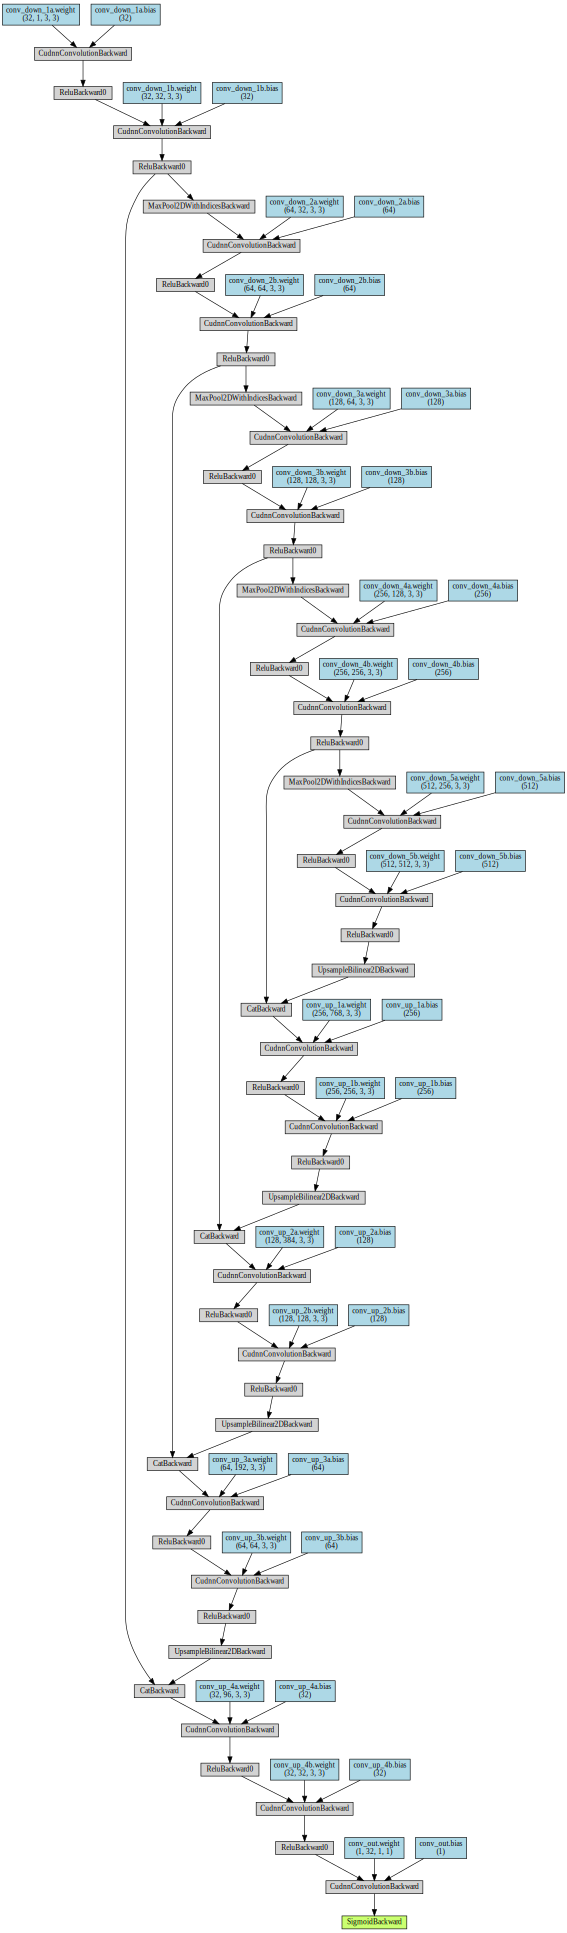

In [11]:
from torchviz import make_dot

for batch_idx, (data, target) in enumerate(cnn.train_loader):
    data, target = data.to(device), target.to(device)
    output = cnn(data)
    break

make_dot(output, params=dict(cnn.named_parameters()))

In [12]:
for e in range(32):
    if e == 2:
        cnn.optimizer = optim.RMSprop(cnn.parameters(), lr=1e-5, momentum=0.9)
    loss = cnn.train_epoch()
    val = cnn.validate()
    print('Epoch', e, 'loss', round(loss, 4), 'val', round(val, 4))

Epoch 0 loss 2.4342 val 0.6078
Epoch 1 loss 0.8174 val 0.6331
Epoch 2 loss 0.5802 val 0.7206
Epoch 3 loss 0.3291 val 0.7874


KeyboardInterrupt: 

In [ ]:
# import matplotlib.pyplot as plt
# %matplotlib inline

# idx = np.argmax(np.sum(target.cpu().numpy(), axis=(1,2,3)))

# mask = target.cpu().numpy()[31]
# pred = output.cpu().numpy()[31]

# plt.imshow(mask.reshape(128, 128))
# plt.show()

# plt.imshow(pred.reshape(128, 128))
# plt.show()